<a href="https://colab.research.google.com/github/springboardmentor458/OBJECT_RECOGNITION_SYSTEM_Infosys_Internship_Oct2024/blob/Lakshya-Jindal/MaskRCNN_W0_coco_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import cv2
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection import maskrcnn_resnet50_fpn

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
ann_file = '/content/drive/My Drive/instances_val2017/instances_val2017.json'
images_dir = '/content/drive/My Drive/val2017/'

In [4]:
# Function to load category mapping from an annotation file
def load_category_mapping(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    category_mapping = {item['id']: item['name'] for item in data['categories']}
    return category_mapping

In [5]:
# Function to make predictions on an image
def predict_image(image_path, model, device, threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct prediction
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract predictions above the threshold
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    masks = predictions[0]['masks'].cpu().numpy()

    # Filter predictions based on the threshold
    valid = scores >= threshold
    boxes = boxes[valid]
    labels = labels[valid]
    scores = scores[valid]
    masks = masks[valid]

    return image, boxes, labels, scores, masks

In [6]:
def overlay_masks(image, masks, transparency=0.5):
    # Create an overlay image starting with the original image
    overlay = image.copy()

    # Loop through each mask
    for mask in masks:
        binary_mask = mask[0] > 0.5  # Convert mask probabilities to binary
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        colored_mask[binary_mask] = [0, 128, 0]  # green mask

        # Add the current mask to the overlay image
        overlay = cv2.addWeighted(overlay, 1, colored_mask, transparency, 0)

    # Blend the overlay with the original image for the final output
    masked_image = cv2.addWeighted(image, 1 - transparency, overlay, transparency, 0)
    return masked_image


In [7]:
# Function to visualize predictions
def visualize_predictions(image, boxes, labels, scores, category_mapping):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', fill=False, linewidth=2))

        label_name = category_mapping.get(label, f"Class {label}")
        plt.text(x1, y1 - 10, f"{label_name} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

In [11]:
#Check GPU is available or not

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

#weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(pretrained=True)
print(f"Using device: {device}")
#Move the model to the available device
model=model.to(device)


Using device: cpu


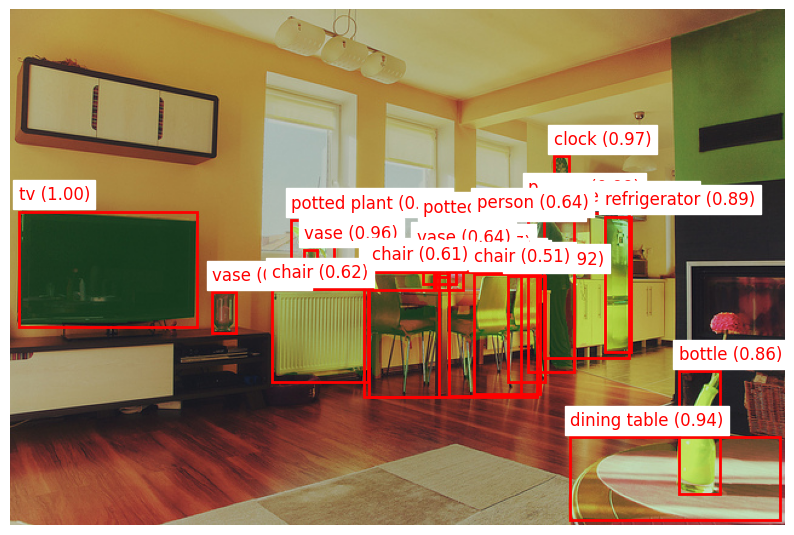

In [12]:
# Path to a single image
img_path = '/content/drive/MyDrive/val2017/000000000139.jpg'

# Load category mapping
category_mapping = load_category_mapping(ann_file)

# Make predictions for the single image
image, boxes, labels, scores, masks = predict_image(img_path, model, device, threshold=0.5)

# Overlay masks on the image with transparency
masked_image = overlay_masks(image, masks, transparency=0.5)

# Visualize predictions with masked objects
visualize_predictions(masked_image, boxes, labels, scores, category_mapping)